# Extracting a pore network using PoreSpy and loading into OpenPNM


In [1]:
import porespy as ps
print("PoreSpy version is " + ps.__version__)
import openpnm as op
print("OpenPNM version is " + op.__version__)
import scipy as sp
import matplotlib.pyplot as plt

PoreSpy version is 1.1.2
OpenPNM version is 2.1.0b1


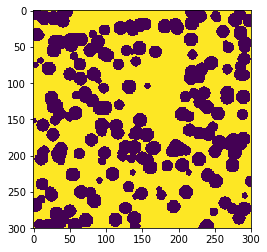

In [2]:
im = ps.generators.overlapping_spheres(shape=[300, 300, 300], radius=10, porosity=0.5, iter_max=0)
plt.imshow(im[:, :, 50])

In [3]:
import scipy.ndimage as spim
def show3D(im):
    im = spim.rotate(input=im, angle=22.5, axes=[0, 1], order=0)
    im = spim.rotate(input=im, angle=45, axes=[2, 1], order=0)
    im = spim.rotate(input=im, angle=-17, axes=[0, 1], order=0, reshape=False)
    mask = im != 0
    view = sp.where(mask.any(axis=2), mask.argmax(axis=2), 0)
    view = view.max() - view
    f = view.max()/5
    view[view == view.max()] = -f
    view = (view + f)**2
    return view

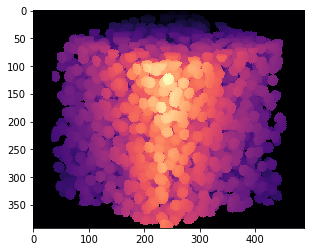

In [4]:
t = show3D(~im)
plt.imshow(t, cmap=plt.cm.magma)

In [5]:
snow = ps.networks.snow(im=im, boundary_faces=['right'])

____________________________________________________________
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  2326
Peaks after trimming saddle points:  1644
Peaks after trimming nearby peaks:  1602
____________________________________________________________
Extracting pore and throat information from image


100%|██████████████████████████████████████████████████████████████████████████████| 1702/1702 [00:28<00:00, 59.64it/s]


In [6]:
net = op.network.GenericNetwork()
net.update(snow)

―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
    SOURCE: openpnm.topotools.topotools._scale_3d_axes 
    TIME STAMP: 2019-05-26 18:23:10,578    


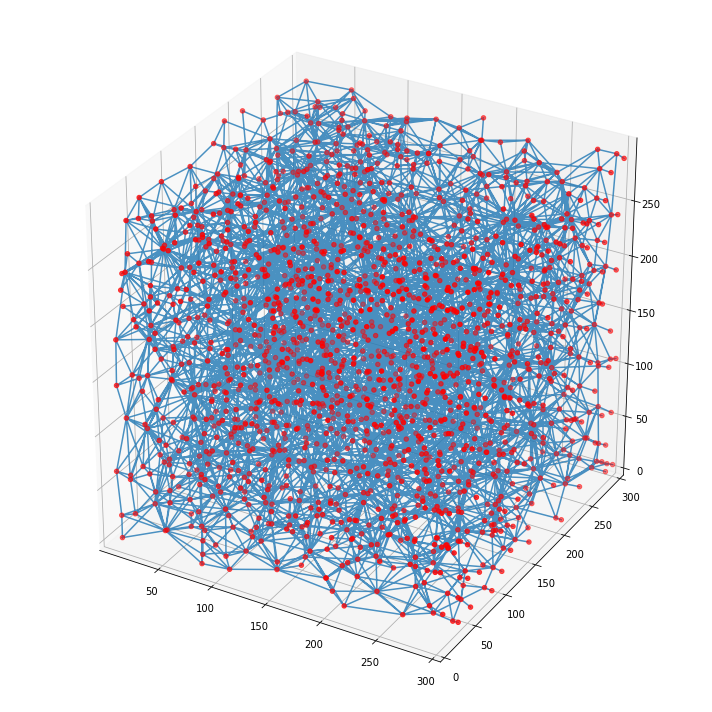

In [7]:
fig = op.topotools.plot_connections(network=net, alpha=0.8)
fig = op.topotools.plot_coordinates(network=net, fig=fig, color='r')
fig.set_size_inches(10, 10)
fig.tight_layout()

In [9]:
m = sp.meshgrid(range(50, 250, 10), range(50, 295, 10))
m = sp.vstack([-10*sp.ones_like(m[1].flatten()), m[0].flatten(), m[1].flatten()]).T
op.topotools.find_surface_pores(network=net, markers=m, label='left')
op.topotools.clone_pores(network=net, pores=net.pores('left'), labels='left_boundary')
net['pore.coords'][net.pores('left_boundary')] *= [0, 1, 1]

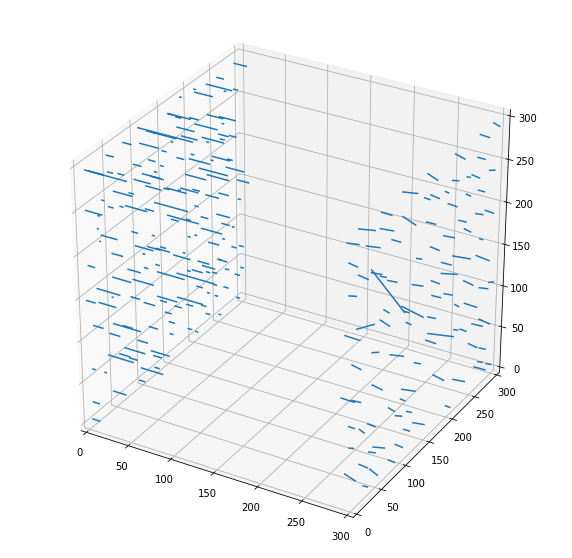

In [10]:
Ps = net.pores('boundary')
net['pore.right_boundary'] = False
net['pore.right_boundary'][Ps] = True
Ts = net.find_neighbor_throats(pores=net.pores('right_boundary'))
net['throat.right_boundary'] = False
net['throat.right_boundary'][Ts] = True
fig = op.topotools.plot_connections(network=net, throats=net.throats(['left_boundary', 'right_boundary']))
fig.set_size_inches(10, 10)

In [27]:
proj = net.project
for geo in proj.geometries().values():
    proj.purge_object(geo)

In [29]:
Ps = net.pores('internal')
Ts = net.throats('internal')
geo_int = op.geometry.GenericGeometry(network=net, pores=Ps, throats=Ts)

In [23]:
Ps = net.pores(['left_boundary', 'right_boundary'])
Ts = net.find_neighbor_throats(pores=Ps)
geo_bnd = op.geometry.GenericGeometry(network=net, pores=Ps, throats=Ts)

In [32]:
print(proj.check_physics_health())

TypeError: check_physics_health() missing 1 required positional argument: 'phase'